In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import train
import json


In [ ]:
dfList = train.transform("data.json")
#df.shape

In [ ]:
df1List = dfList
dfList = df1List
for df in dfList:
    scaler = MinMaxScaler(feature_range=(0,1)).fit(df)
    df = scaler.transform(df)
#print(dfList[12])
#print(dfList[0].head(5))

In [2]:
def eval(accList, precisionList, tprList, farList, frrList, y, y_pred):
    avgaccuracy = 0
    avgPrecision = 0
    avgTpr = 0
    avgFar = 0
    avgFrr = 0
    for i in range(len(accList)):
        avgaccuracy += accList[i]
        avgPrecision += precisionList[i]
        avgTpr += tprList[i]
        avgFar += farList[i]
        avgFrr += frrList[i]
    avgaccuracy = avgaccuracy / len(accList)
    avgPrecision = avgPrecision / len(precisionList)
    avgTpr = avgTpr / len(tprList)
    avgFar = avgFar / len(farList)
    avgFrr = avgFrr / len(frrList)
    
    fprROC, tprROC, threshold = roc_curve(y, y_pred, pos_label=1) #fprROC == avgFar, tprROC == avgTpr
    fnrROC = 1 - tprROC #fnrROC == avgFrr
    EER = fprROC[np.nanargmin(np.absolute((fnrROC - fprROC)))]

    print("average acc = "+str(avgaccuracy))
    print("average precision = "+str(avgPrecision))
    print("average TPR = "+str(avgTpr))
    print("average FAR = "+str(avgFar))
    print("average FRR = "+str(avgFrr))
    print("average EER = "+str(EER))

In [ ]:
#Truly train the RF models that are going to be used

from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

precisionList = []
accList = []
tprList = []
farList = []
frrList = []
tnTotal, fpTotal, fnTotal, tpTotal = 0, 0, 0, 0

i=0
for df in dfList: 
    X = df.drop(columns=['label'])
    X = X.drop(columns=['pressureMedian'])
    X = X.drop(columns=['startX'])
    X = X.drop(columns=['startY'])
    X = X.drop(columns=['endX'])
    X = X.drop(columns=['endY'])

    X = X.drop(columns=['MXmax'])
    X = X.drop(columns=['MXmin'])
    X = X.drop(columns=['MXmean'])
    X = X.drop(columns=['MXmedian'])
    X = X.drop(columns=['MXSD'])
    X = X.drop(columns=['MYmax'])
    X = X.drop(columns=['MYmin'])
    X = X.drop(columns=['MYmean'])
    X = X.drop(columns=['MYmedian'])
    X = X.drop(columns=['MYSD'])
    X = X.drop(columns=['MZmax'])
    X = X.drop(columns=['MZmin'])
    X = X.drop(columns=['MZmean'])
    X = X.drop(columns=['MZmedian'])
    X = X.drop(columns=['MZSD'])

    y = df['label']
    predicted_targets = np.array([])
    actual_targets = np.array([])
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42, stratify=y) #stratify=y means to keep the same ratio of labels in test set as the training set
    #X_re, y_re = SMOTE(random_state=42, k_neighbors=2).fit_resample(X_train, y_train.astype('int')) #only apply SMOTE on training dataset
    X_re, y_re = RandomUnderSampler(random_state=42).fit_resample(X_train, y_train.astype('int'))
    
    RF_model = RandomForestClassifier(n_estimators=22)
    RF_model.fit(X_re,y_re)
    
    y_pred = RF_model.predict(X_test)
    predicted_targets = np.append(predicted_targets, y_pred)
    actual_targets = np.append(actual_targets, y_test)
    
    cm = confusion_matrix(actual_targets.astype('int'), predicted_targets)
    
    plt.figure(figsize=(12,5))
    sns.heatmap(cm,square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
    plt.xlabel('Pred',fontsize=20)
    plt.ylabel('True',fontsize=20)
    plt.show()
    
    
    tn, fp, fn, tp = cm.ravel()
    tnTotal += tn
    fpTotal += fp
    fnTotal += fn
    tpTotal += tp
    
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    tpr = tp/(tp+fn)
    far = fp/(fp+tn)
    frr = fn/(fn+tp)
    
    accList.append(accuracy)
    precisionList.append(precision)
    tprList.append(tpr)
    farList.append(far)
    frrList.append(frr)
    
    print("acc = "+str(accuracy))
    print("precision = "+str(precision))
    print("TPR = "+str(tpr))
    print("FAR = "+str(far))
    print("FRR = "+str(frr))

    initial_types = [
        ('input_data_type', FloatTensorType([None, 36]))
    ]

    converted_model = convert_sklearn(RF_model, initial_types=initial_types)
    with open(f"./models/model{i}.onnx", "wb") as f:
        f.write(converted_model.SerializeToString())
    i+=1
    
    
eval(tnTotal, fpTotal, fnTotal, tpTotal, actual_targets.astype('int'), predicted_targets, len(dfList))

plt.figure(figsize=(12,5))
sns.heatmap(np.array([[tnTotal, fpTotal], [fnTotal, tpTotal]]),square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
plt.xlabel('Pred',fontsize=20)
plt.ylabel('True',fontsize=20)
plt.show()


In [ ]:
df = train.onlyOneUser("temp.json", "1094842")
#["1092954", "dama0623", "1094908", "4109034029", "611034", "1094841", "D1186959",
#                "411411159", "1094845", "1094842", "110", "pomiii5093", "1092574", "anyu5471", "px",
#                "wardlin", "lenny", "1092960", "1092923", "1092950", "1092942", "1092928", "1092922"]
#scaler = MinMaxScaler(feature_range=(0,1)).fit(df)
#df = scaler.transform(df)

In [ ]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnxruntime as rt

precisionList = []
accList = []
tprList = []
farList = []
frrList = []
tnTotal, fpTotal, fnTotal, tpTotal = 0, 0, 0, 0

y = df['label']
X = df.drop(columns=['label'])
X = X.drop(columns=['pressureMedian'])
X = X.drop(columns=['sizeMedian'])

predicted_targets = np.array([])
actual_targets = np.array([])

sess = rt.InferenceSession(
        f"./models/SMOTERF-newData/model9.onnx", providers=rt.get_available_providers())
input_name = sess.get_inputs()[0].name
    #print(X_test.astype(np.float32).to_dict('split')['data'])
    #break
y_pred = sess.run(None, {input_name: X.astype(np.float32).to_dict('split')['data']})[0]

predicted_targets = np.append(predicted_targets, y_pred)
actual_targets = np.append(actual_targets, y)

cm = confusion_matrix(actual_targets.astype('int'), predicted_targets.astype('int'), labels=[False, True])
plt.figure(figsize=(12,5))
sns.heatmap(cm,square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
plt.xlabel('Pred',fontsize=20)
plt.ylabel('True',fontsize=20)
plt.show()

tn, fp, fn, tp = cm.ravel()
tnTotal += tn
fpTotal += fp
fnTotal += fn
tpTotal += tp

accuracy = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
tpr = tp/(tp+fn)
far = fp/(fp+tn)
frr = fn/(fn+tp)

accList.append(accuracy)
precisionList.append(precision)
tprList.append(tpr)
farList.append(far)
frrList.append(frr)

print("acc = "+str(accuracy))
print("precision = "+str(precision))
print("TPR = "+str(tpr))
print("FAR = "+str(far))
print("FRR = "+str(frr))
    
#eval(accList, precisionList, tprList, farList, frrList, actual_targets.astype('int'), predicted_targets)
#plt.figure(figsize=(12,5))
#sns.heatmap(np.array([[tnTotal, fpTotal], [fnTotal, tpTotal]]),square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
#plt.xlabel('Pred',fontsize=20)
#plt.ylabel('True',fontsize=20)
#plt.show()


In [ ]:
from sklearn.utils import shuffle

dfList = train.transform("data.json")

userList = ["1092954", "dama0623", "1094908", "4109034029", "611034", "1094841", "D1186959",
                "411411159", "1094845", "1094842", "110", "pomiii5093", "1092574", "anyu5471", "px",
                "wardlin", "lenny", "1092960", "1092923", "1092950", "1092942", "1092928", "1092922", "29282928"]

with open("temp.json", 'r') as jsonFile:
        data = json.load(jsonFile)
        for user in data:
            index = userList.index(user)
            df = pd.DataFrame()
            df = train.onlyOneUser("temp.json", user)

            length = len(df)

            df = shuffle(df, random_state=42)
            df = df[:length//2] #first half for training, second half for testing

            dfList[index] = pd.concat([dfList[index], df])
            
for df in dfList:
    scaler = MinMaxScaler(feature_range=(0,1)).fit(df)
    df = scaler.transform(df)

In [ ]:
#Truly train the RF models that are going to be used

from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

precisionList = []
accList = []
tprList = []
farList = []
frrList = []
tnTotal, fpTotal, fnTotal, tpTotal = 0, 0, 0, 0

i=0
for df in dfList: 
    X = df.drop(columns=['label'])
    X = X.drop(columns=['pressureMedian'])
    X = X.drop(columns=['startX'])
    X = X.drop(columns=['startY'])
    X = X.drop(columns=['endX'])
    X = X.drop(columns=['endY'])

    X = X.drop(columns=['MXmax'])
    X = X.drop(columns=['MXmin'])
    X = X.drop(columns=['MXmean'])
    X = X.drop(columns=['MXmedian'])
    X = X.drop(columns=['MXSD'])
    X = X.drop(columns=['MYmax'])
    X = X.drop(columns=['MYmin'])
    X = X.drop(columns=['MYmean'])
    X = X.drop(columns=['MYmedian'])
    X = X.drop(columns=['MYSD'])
    X = X.drop(columns=['MZmax'])
    X = X.drop(columns=['MZmin'])
    X = X.drop(columns=['MZmean'])
    X = X.drop(columns=['MZmedian'])
    X = X.drop(columns=['MZSD'])

    y = df['label']
    predicted_targets = np.array([])
    actual_targets = np.array([])
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42, stratify=y) #stratify=y means to keep the same ratio of labels in test set as the training set
    #X_re, y_re = SMOTE(random_state=42, k_neighbors=2).fit_resample(X_train, y_train.astype('int')) #only apply SMOTE on training dataset
    X_re, y_re = RandomUnderSampler(random_state=42).fit_resample(X_train, y_train.astype('int'))
    
    RF_model = RandomForestClassifier(n_estimators=22)
    RF_model.fit(X_re,y_re)
    
    #import pickle
    #pickle.dump(RF_model, open(f"./models/rf{i}.pickle", "wb"))
    
    y_pred = RF_model.predict(X_test)
    predicted_targets = np.append(predicted_targets, y_pred)
    actual_targets = np.append(actual_targets, y_test)
    
    cm = confusion_matrix(actual_targets.astype('int'), predicted_targets)
    
    plt.figure(figsize=(12,5))
    sns.heatmap(cm,square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
    plt.xlabel('Pred',fontsize=20)
    plt.ylabel('True',fontsize=20)
    plt.show()
    
    
    tn, fp, fn, tp = cm.ravel()
    tnTotal += tn
    fpTotal += fp
    fnTotal += fn
    tpTotal += tp
    
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    tpr = tp/(tp+fn)
    far = fp/(fp+tn)
    frr = fn/(fn+tp)
    
    accList.append(accuracy)
    precisionList.append(precision)
    tprList.append(tpr)
    farList.append(far)
    frrList.append(frr)
    
    print("acc = "+str(accuracy))
    print("precision = "+str(precision))
    print("TPR = "+str(tpr))
    print("FAR = "+str(far))
    print("FRR = "+str(frr))

    initial_types = [
        ('input_data_type', FloatTensorType([None, 36]))
    ]

    converted_model = convert_sklearn(RF_model, initial_types=initial_types)
    with open(f"./models/model{i}.onnx", "wb") as f:
        f.write(converted_model.SerializeToString())
    i+=1
    
eval(accList, precisionList, tprList, farList, frrList, actual_targets.astype('int'), predicted_targets)

plt.figure(figsize=(12,5))
sns.heatmap(np.array([[tnTotal, fpTotal], [fnTotal, tpTotal]]),square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
plt.xlabel('Pred',fontsize=20)
plt.ylabel('True',fontsize=20)
plt.show()

In [3]:
dfList = train.transformSplit("temp.json")


110


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df3])


119


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


133


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


107


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


114


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


81


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


118


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


92


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


106


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


117


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


106


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


117


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


108


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


159


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


136


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


123


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


110


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


78


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


67


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


80


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


56


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


85


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


89


c:\Main\Code\ml-app\train.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Main\Code\ml-app\train.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


In [ ]:
dfList = train.transform("temp.json")

NOW SHOWING: 1092928


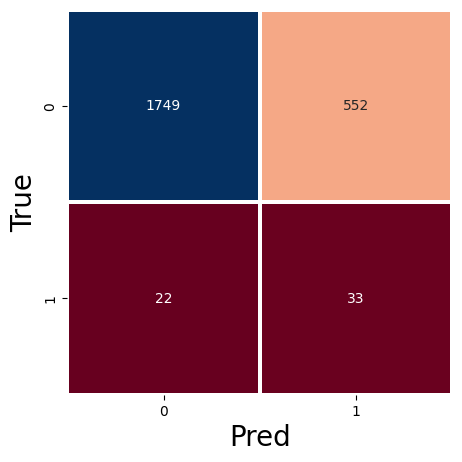

acc = 0.7563667232597623
precision = 0.05641025641025641
TPR = 0.6
FAR = 0.23989569752281617
FRR = 0.4
NOW SHOWING: D1186959


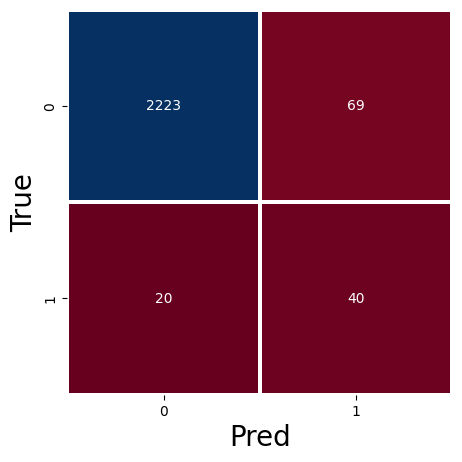

acc = 0.9621598639455783
precision = 0.3669724770642202
TPR = 0.6666666666666666
FAR = 0.030104712041884817
FRR = 0.3333333333333333
NOW SHOWING: 1092922


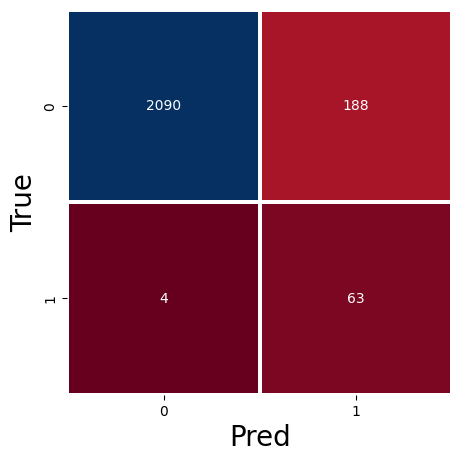

acc = 0.9181236673773987
precision = 0.250996015936255
TPR = 0.9402985074626866
FAR = 0.08252853380158033
FRR = 0.05970149253731343
NOW SHOWING: 1094841


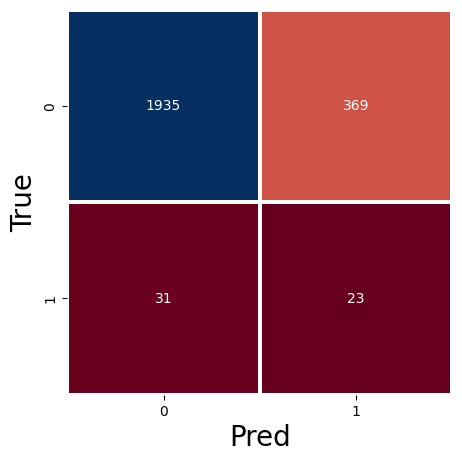

acc = 0.8303647158608991
precision = 0.058673469387755105
TPR = 0.42592592592592593
FAR = 0.16015625
FRR = 0.5740740740740741
NOW SHOWING: 1094908


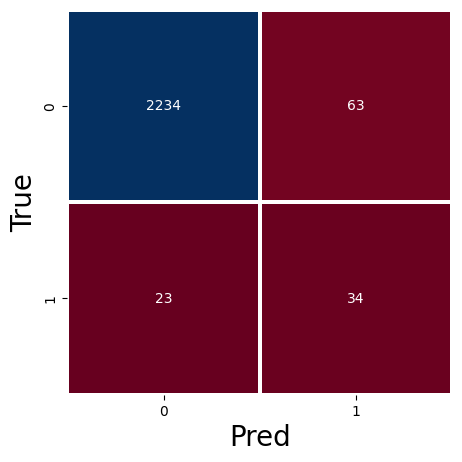

acc = 0.9634664401019541
precision = 0.35051546391752575
TPR = 0.5964912280701754
FAR = 0.027427078798432737
FRR = 0.40350877192982454
NOW SHOWING: lenny


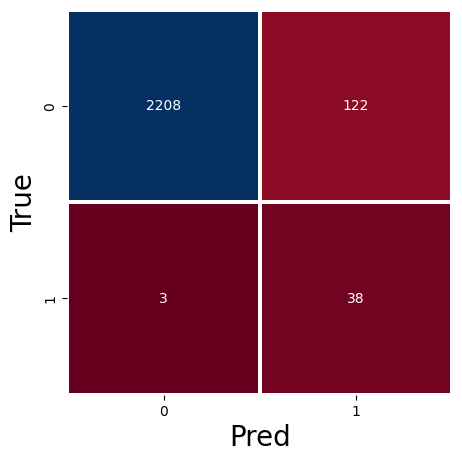

acc = 0.9472796288485871
precision = 0.2375
TPR = 0.926829268292683
FAR = 0.05236051502145923
FRR = 0.07317073170731707
NOW SHOWING: dama0623


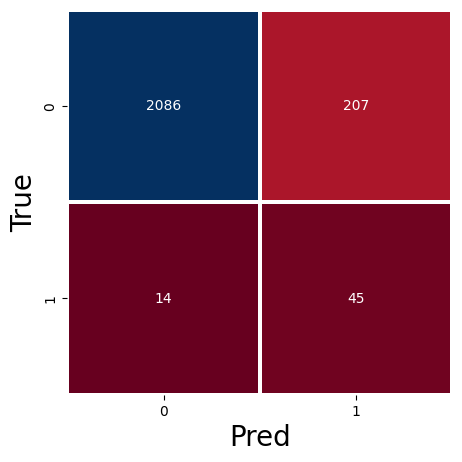

acc = 0.9060374149659864
precision = 0.17857142857142858
TPR = 0.7627118644067796
FAR = 0.09027474923680767
FRR = 0.23728813559322035
NOW SHOWING: pomiii5093


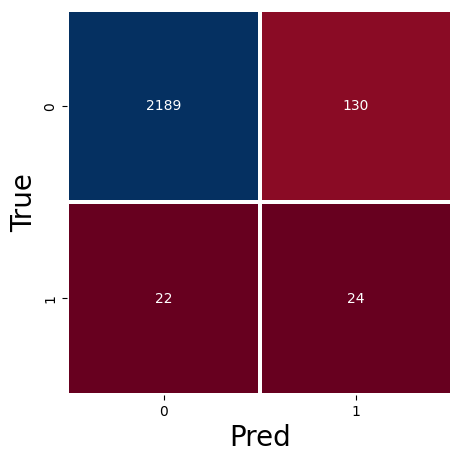

acc = 0.9357293868921776
precision = 0.15584415584415584
TPR = 0.5217391304347826
FAR = 0.056058645968089696
FRR = 0.4782608695652174
NOW SHOWING: 1092954


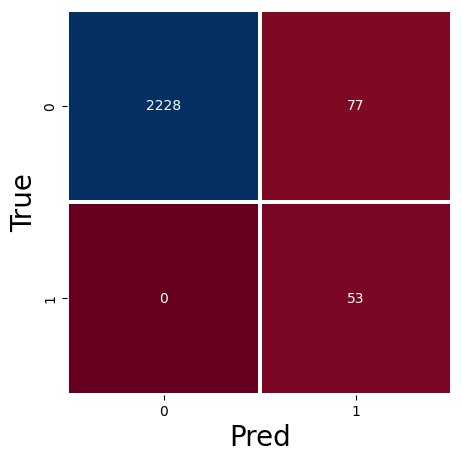

acc = 0.9673452078032231
precision = 0.4076923076923077
TPR = 1.0
FAR = 0.0334056399132321
FRR = 0.0
NOW SHOWING: 4109034029


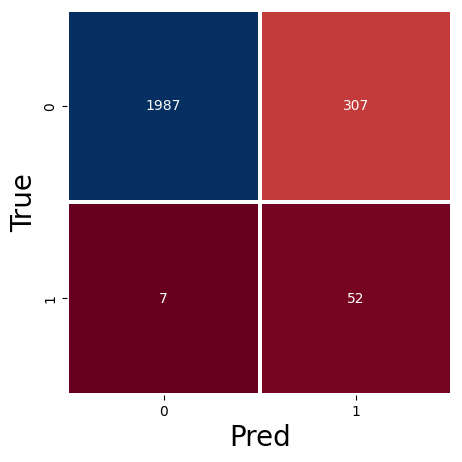

acc = 0.8665533361665958
precision = 0.14484679665738162
TPR = 0.8813559322033898
FAR = 0.13382737576285963
FRR = 0.11864406779661017
NOW SHOWING: 110


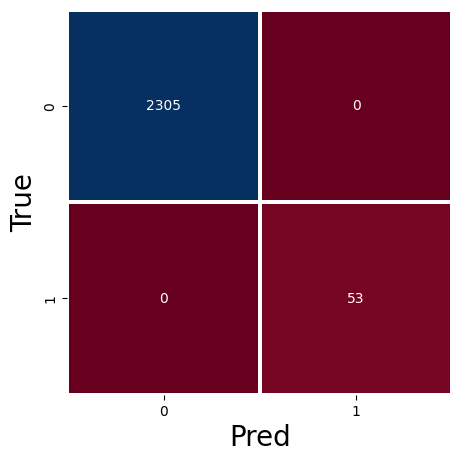

acc = 1.0
precision = 1.0
TPR = 1.0
FAR = 0.0
FRR = 0.0
NOW SHOWING: 1094845


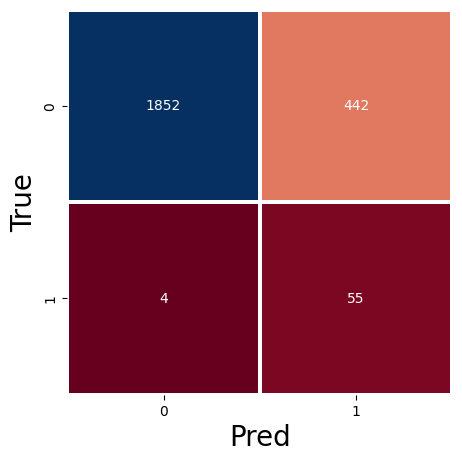

acc = 0.8104547386315342
precision = 0.11066398390342053
TPR = 0.9322033898305084
FAR = 0.1926765475152572
FRR = 0.06779661016949153
NOW SHOWING: 611034


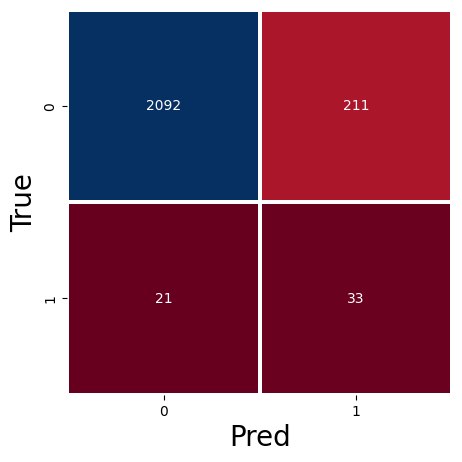

acc = 0.9015697921086127
precision = 0.13524590163934427
TPR = 0.6111111111111112
FAR = 0.09161962657403387
FRR = 0.3888888888888889
NOW SHOWING: 1092942


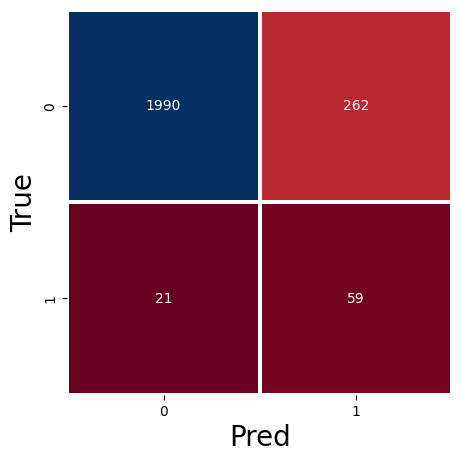

acc = 0.8786449399656947
precision = 0.1838006230529595
TPR = 0.7375
FAR = 0.11634103019538189
FRR = 0.2625
NOW SHOWING: 1092574


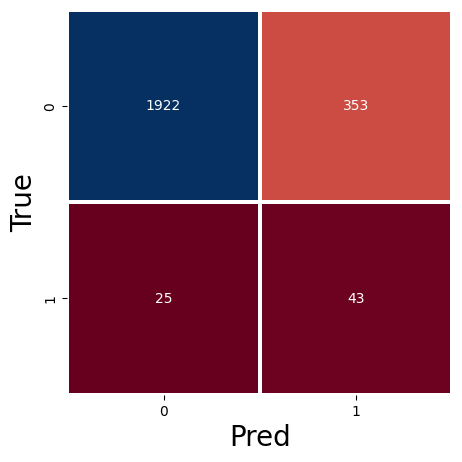

acc = 0.8386683738796414
precision = 0.10858585858585859
TPR = 0.6323529411764706
FAR = 0.15516483516483517
FRR = 0.36764705882352944
NOW SHOWING: 1092923


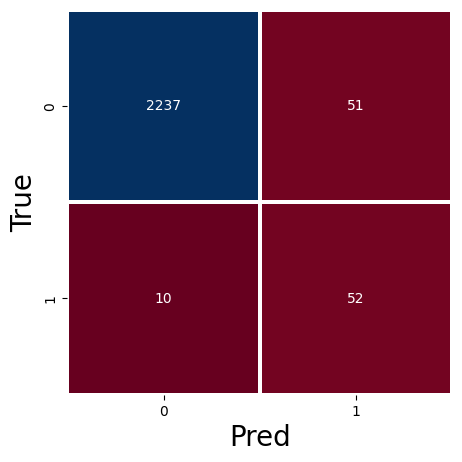

acc = 0.9740425531914894
precision = 0.5048543689320388
TPR = 0.8387096774193549
FAR = 0.022290209790209792
FRR = 0.16129032258064516
NOW SHOWING: 411411159


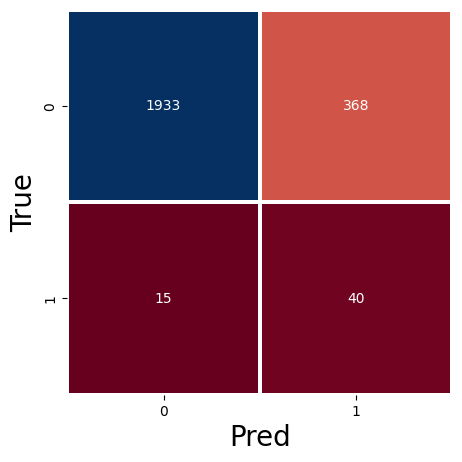

acc = 0.8374363327674024
precision = 0.09803921568627451
TPR = 0.7272727272727273
FAR = 0.15993046501521077
FRR = 0.2727272727272727
NOW SHOWING: px


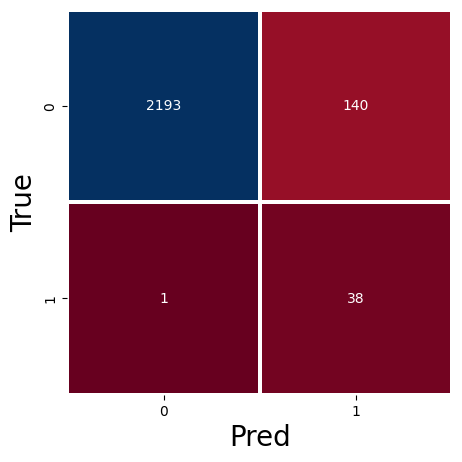

acc = 0.9405564924114671
precision = 0.21348314606741572
TPR = 0.9743589743589743
FAR = 0.06000857265323618
FRR = 0.02564102564102564
NOW SHOWING: anyu5471


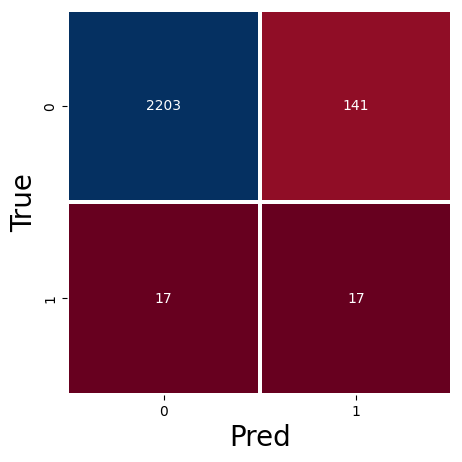

acc = 0.9335576114381834
precision = 0.10759493670886076
TPR = 0.5
FAR = 0.06015358361774744
FRR = 0.5
NOW SHOWING: 1094842


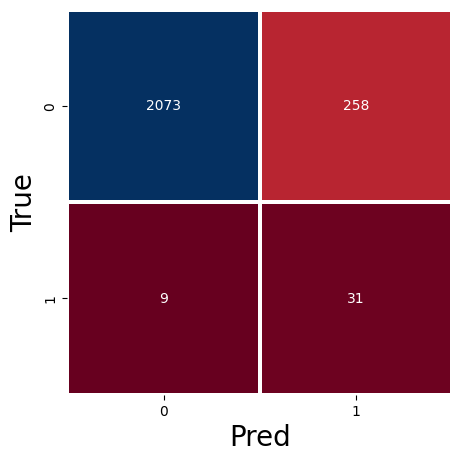

acc = 0.8873892872205821
precision = 0.10726643598615918
TPR = 0.775
FAR = 0.11068211068211069
FRR = 0.225
NOW SHOWING: 1092950


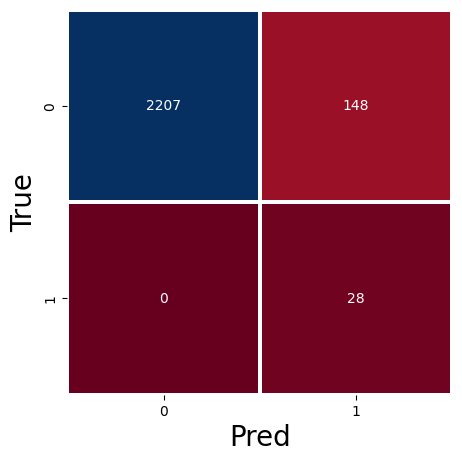

acc = 0.9378934116659673
precision = 0.1590909090909091
TPR = 1.0
FAR = 0.06284501061571125
FRR = 0.0
NOW SHOWING: 1092960


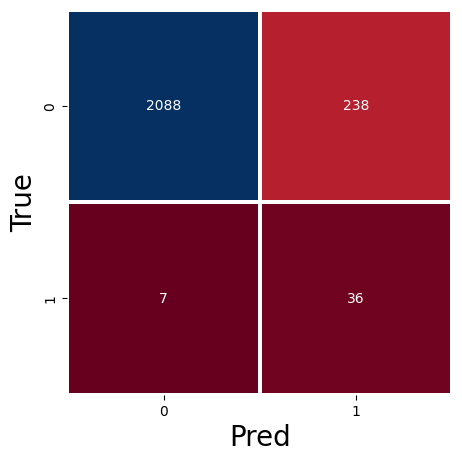

acc = 0.8965808357956944
precision = 0.13138686131386862
TPR = 0.8372093023255814
FAR = 0.10232158211521926
FRR = 0.16279069767441862
NOW SHOWING: 29282928


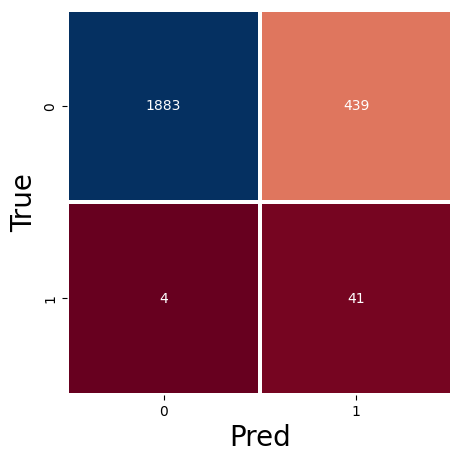

acc = 0.812843261512463
precision = 0.08541666666666667
TPR = 0.9111111111111111
FAR = 0.18906115417743324
FRR = 0.08888888888888889
average acc = 0.9001332180787346
average precision = 0.22406309909195923
average TPR = 0.773862946002997
average FAR = 0.09691886635580647
average FRR = 0.22613705399700307
average EER = 0.18906115417743324


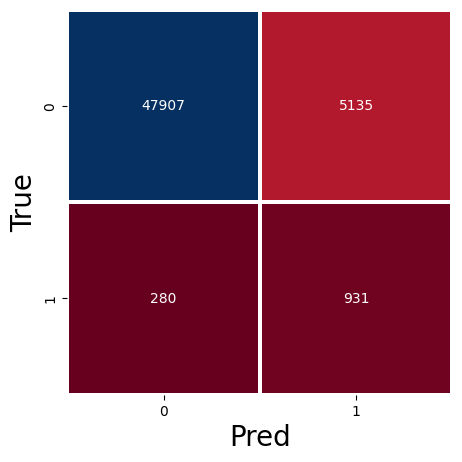

In [5]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnxruntime as rt
import json

userOrder = []
userList = ["1092954", "dama0623", "1094908", "4109034029", "611034", "1094841", "D1186959",
                "411411159", "1094845", "1094842", "110", "pomiii5093", "1092574", "anyu5471", "px",
                "wardlin", "lenny", "1092960", "1092923", "1092950", "1092942", "1092928", "1092922", "29282928"]

with open("evaluationData.json", 'r') as f:
    data = json.load(f)
    numSubject = len(data)
    for i in data.keys():
        userOrder.append(userList.index(i))
        
i=0

precisionList = []
accList = []
tprList = []
farList = []
frrList = []
tnTotal, fpTotal, fnTotal, tpTotal = 0, 0, 0, 0

for df in dfList:
    y = df['label']
    X = df.drop(columns=['label'])
    X = X.drop(columns=['pressureMedian'])
    X = X.drop(columns=['startX'])
    X = X.drop(columns=['startY'])
    X = X.drop(columns=['endX'])
    X = X.drop(columns=['endY'])

    X = X.drop(columns=['MXmax'])
    X = X.drop(columns=['MXmin'])
    X = X.drop(columns=['MXmean'])
    X = X.drop(columns=['MXmedian'])
    X = X.drop(columns=['MXSD'])
    X = X.drop(columns=['MYmax'])
    X = X.drop(columns=['MYmin'])
    X = X.drop(columns=['MYmean'])
    X = X.drop(columns=['MYmedian'])
    X = X.drop(columns=['MYSD'])
    X = X.drop(columns=['MZmax'])
    X = X.drop(columns=['MZmin'])
    X = X.drop(columns=['MZmean'])
    X = X.drop(columns=['MZmedian'])
    X = X.drop(columns=['MZSD'])

    predicted_targets = np.array([])
    actual_targets = np.array([])

    sess = rt.InferenceSession(
            #"./models/SMOTERF-newData/model{userOrder[i]}.onnx", providers=rt.get_available_providers())
            #f"./models/RandomSamplingRF-newData/model{userOrder[i]}.onnx", providers=rt.get_available_providers())
            #f"./models/model{userOrder[i]}.onnx", providers=rt.get_available_providers())
            #f"./models/SMOTEold/model{userOrder[i]}.onnx", providers=rt.get_available_providers())
            f"./models/RSold/model{userOrder[i]}.onnx", providers=rt.get_available_providers())
    
    input_name = sess.get_inputs()[0].name
        #print(X_test.astype(np.float32).to_dict('split')['data'])
        #break
    y_pred = sess.run(None, {input_name: X.astype(np.float32).to_dict('split')['data']})[0]

    predicted_targets = np.append(predicted_targets, y_pred)
    actual_targets = np.append(actual_targets, y)

    print("NOW SHOWING: " + str(userList[userOrder[i]]))
    cm = confusion_matrix(actual_targets.astype('int'), predicted_targets.astype('int'), labels=[False, True])
    plt.figure(figsize=(12,5))
    sns.heatmap(cm,square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
    plt.xlabel('Pred',fontsize=20)
    plt.ylabel('True',fontsize=20)
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    tnTotal += tn
    fpTotal += fp
    fnTotal += fn
    tpTotal += tp

    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    tpr = tp/(tp+fn)
    far = fp/(fp+tn)
    frr = fn/(fn+tp)

    accList.append(accuracy)
    precisionList.append(precision)
    tprList.append(tpr)
    farList.append(far)
    frrList.append(frr)

    print("acc = "+str(accuracy))
    print("precision = "+str(precision))
    print("TPR = "+str(tpr))
    print("FAR = "+str(far))
    print("FRR = "+str(frr))
    i+=1
    
eval(accList, precisionList, tprList, farList, frrList, actual_targets.astype('int'), predicted_targets)

plt.figure(figsize=(12,5))
sns.heatmap(np.array([[tnTotal, fpTotal], [fnTotal, tpTotal]]),square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
plt.xlabel('Pred',fontsize=20)
plt.ylabel('True',fontsize=20)
plt.show()
